In [0]:
!pip install librosa


    100% |████████████████████████████████| 1.6MB 15.2MB/s 
    100% |████████████████████████████████| 327kB 13.7MB/s 
    100% |████████████████████████████████| 3.2MB 8.8MB/s 
    100% |████████████████████████████████| 16.1MB 2.9MB/s 
  Running setup.py bdist_wheel for librosa ... - \ done
  Stored in directory: /root/.cache/pip/wheels/18/b8/10/f0f8f6ac60668a5cd75596cf14c25bb6b3ea1ecd815f058b7e
  Running setup.py bdist_wheel for audioread ... - done
  Stored in directory: /root/.cache/pip/wheels/53/02/90/7b5c4081b7470c550ab605f600bad237dde12a6b8999b11f50
  Running setup.py bdist_wheel for resampy ... - \ done
  Stored in directory: /root/.cache/pip/wheels/ff/4f/ed/2e6c676c23efe5394bb40ade50662e90eb46e29b48324c5f9b
Successfully built librosa audioread resampy


In [0]:
!pip install kaggle

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dharrana","key":"1d2ee1bff2afc2b0a761ff8ff70a9214"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c tensorflow-speech-recognition-challenge

  0% 0.00/501k [00:00<?, ?B/s]
100% 501k/501k [00:00<00:00, 66.5MB/s]
100% 1.04G/1.04G [00:09<00:00, 115MB/s]
100% 1.04G/1.04G [00:09<00:00, 113MB/s]
 99% 2.45G/2.46G [00:24<00:00, 104MB/s] 
100% 2.46G/2.46G [00:24<00:00, 108MB/s]
  0% 0.00/50.0 [00:00<?, ?B/s]
100% 50.0/50.0 [00:00<00:00, 68.4kB/s]


In [0]:
!ls 

kaggle.json		      sample_data	    test.7z
link_to_gcp_credits_form.txt  sample_submission.7z  train.7z


In [0]:
!7z x train.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 1121103842 bytes (1070 MiB)

Extracting archive: train.7z
--
Path = train.7z
Type = 7z
Physical Size = 1121103842
Headers Size = 389133
Method = Delta LZMA2:24
Solid = +
Blocks = 2

  0%      0% 39 - train/audio/_background_noise_/dude_miaowing.wav                                                            0% 40 - train/audio/_background_noise_/exercise_bike.wav                                                            0% 42 - train/audio/_background_noise_/running_tap.wav

In [0]:
!rm test.7z
!rm train.7z
!rm sample_submission.7z
!rm link_to_gcp_credits_form.txt

In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Read the Validation.txt and testing.txt and create a dictionary

In [0]:
import os
import re
import glob
import librosa
import numpy as np
import pandas as pd
from IPython import get_ipython
import pickle
from sklearn.preprocessing import normalize, MinMaxScaler
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split      


In [0]:
TRAIN_WORDS = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

In [0]:
file_path = os.path.dirname(os.path.abspath('__file__'))
print(file_path)
filename = "validation_list.txt"
file_path_full=file_path+"/" +filename

validation={}
f=open(file_path_full,'r')
l=f.readline()
while(l !=''):
    label=re.findall('[a-z]*/',l)
    filename=re.findall('/[a-z0-9_]*.wav',l)
    label=label[0][:-1]
    filename=filename[0][1:]
    if label in TRAIN_WORDS:
      if(label not in validation):
              validation[label]=[filename]
      else:
              validation[label].append(filename)

    l=f.readline()
f.close()

for k in validation:
  print(k,len(validation[k]))

/content
down 264
go 260
left 247
no 270
off 256
on 257
right 256
stop 246
up 260
yes 261


In [0]:
filename = "/testing_list.txt"
file_path_full=file_path+"/" +filename

test={}
f=open(file_path_full,'r')
l=f.readline()
while(l !=''):
    label=re.findall('[a-z]*/',l)
    filename=re.findall('/[a-z0-9_]*.wav',l)
    label=label[0][:-1]
    filename=filename[0][1:]
    if label in TRAIN_WORDS:
      if(label not in test):
              test[label]=[filename]
      else:
              test[label].append(filename)

    l=f.readline()
f.close()

for k in test:
  print(k,len(test[k]))

down 253
go 251
left 267
no 252
off 262
on 246
right 259
stop 249
up 272
yes 256


Store all the class in a dictionary with index values

In [0]:
classes={}
for i, k in enumerate(validation):
    classes[k]=i
classes    

{'down': 0,
 'go': 1,
 'left': 2,
 'no': 3,
 'off': 4,
 'on': 5,
 'right': 6,
 'stop': 7,
 'up': 8,
 'yes': 9}

**Data Pre-Pocessing**

In [0]:
file_path = os.path.dirname(os.path.abspath('__file__'))
audio_dir=file_path+"/train/audio"
save_dir=file_path


In [0]:
def one_hot_encode(labels,classes):
    labels=np.array(labels, dtype=np.int)
    n_labels = len(labels)
    n_unique_labels =len(classes)
    one_hot_encode = np.zeros((n_labels, n_unique_labels))
    one_hot_encode[np.arange(n_labels),labels] = 1
    return one_hot_encode

def get_random_patch(frames, num_frames):
    # TODO: Randomize
    start_frame = 0
    return frames[:, start_frame:start_frame + num_frames]

def wav2mfcc(wave,sr, max_pad_len=11):
    wave = wave[::3]
    mfcc = librosa.feature.mfcc(wave, sr=16000)
    pad_width = max_pad_len - mfcc.shape[1]
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    return mfcc
  
def windows(data, window_size):
    start = 0
    while start < len(data):
        yield start, start + window_size
        start += (window_size / 2)

TARGET_DURATION=22050  
SAMPLE_RATE= 22050
def add_background_noises(audio, background_wav, volume_range=0.1):
    """
    Given audio and background noise, mixes the two together giving the background noise a
    volume between 0 and volume_range
    :param audio: A list of floating point values representing a wav file.
    :param background_wav: A list of floating point values representing a silence wav file.
    :param volume_range: A floating point value for the max volume of the background noise
    :return: audio: An audio representation with the background noise mixed in.
    """
    bg_audio = background_wav
    bg_audio_start_idx = np.random.randint(bg_audio.shape[0] - TARGET_DURATION)
    bg_audio_slice = bg_audio[bg_audio_start_idx: bg_audio_start_idx + len(audio)] * np.random.uniform(0, volume_range)
    return audio + bg_audio_slice    

def pitch_scaling(audio, max_step_shift=2.0):
    """
    Increase/decreases the pitch of the audio between 0 and max_step_shift steps.
    :param audio: A list of floating point values representing a wav file.
    :param max_step_shift: A floating point value for the steps the pitch should be shifted by.
    :return: audio: Time stretched audio.
    """
    steps = np.random.uniform(-max_step_shift, max_step_shift)
    return librosa.effects.pitch_shift(audio, sr=SAMPLE_RATE, n_steps=steps)   
  
def create_vaildationSet(mfcc_specs,labels,split_ratio,random_state=42 ):
    X_train, X_valid, y_train, y_valid=train_test_split(mfcc_specs, labels, test_size= split_ratio, random_state=random_state, shuffle=True)              
    return  X_train, X_valid, y_train, y_valid

def extract_mfcc_No_Noise(parent_dir, sub_dirs,classes,backgroundNoisePath):
    mfcc_vectors=[]
    labels=[]
    for l, sub_dir in enumerate(sub_dirs):
        print('parsing %s...' % sub_dir)
        for file in sub_dirs[sub_dir]:
            for fn in glob.glob(os.path.join(parent_dir, sub_dir,file)):
                print('fn is ', fn)
                audio_clip, sr = librosa.load(fn, mono=True, sr=None)
                label = sub_dir  # TODO change to fn.split('/').pop().split('-')[1]
                #print(len(audio_clip))
                mfcc=wav2mfcc(audio_clip, sr, max_pad_len=11)
                mfcc_vectors.append(mfcc)
                labels.append(classes[label])
                        
    mfcc_vectors=np.array(mfcc_vectors)                
    mfcc_specs=mfcc_vectors.reshape(len(mfcc_vectors),20, 11,1)                
    labels = one_hot_encode(labels,classes)                
    return mfcc_specs,labels
  
def extract_mfcc(parent_dir, sub_dirs,classes,backgroundNoisePath):
    mfcc_vectors=[]
    labels=[]
    for l, sub_dir in enumerate(sub_dirs):
        print('parsing %s...' % sub_dir)
        for file in sub_dirs[sub_dir]:
            for fn in glob.glob(os.path.join(parent_dir, sub_dir,file)):
                print('fn is ', fn)
                audio_clip, sr = librosa.load(fn, mono=True, sr=None)
                label = sub_dir  # TODO change to fn.split('/').pop().split('-')[1]
                #print(len(audio_clip))
                for b in range(0,len(backgroundNoisePath)+1):
                    if b >=1:
                        print("Adding Background Noise: ",backgroundNoisePath[b-1])
                        bkgrndNoise,srWBN =librosa.load(backgroundNoisePath[b-1])
                        sound_clip=add_background_noises(audio_clip, bkgrndNoise, volume_range=0.9)
                        mfcc=wav2mfcc(sound_clip, sr, max_pad_len=11)
                        mfcc_vectors.append(mfcc)
                    else:
                        mfcc=wav2mfcc(audio_clip, sr, max_pad_len=11)
                        mfcc_vectors.append(mfcc)
                    labels.append(classes[label])
                        
    mfcc_vectors=np.array(mfcc_vectors)                
    mfcc_specs=mfcc_vectors.reshape(len(mfcc_vectors),20, 11,1)                
    labels = one_hot_encode(labels,classes)                
    return mfcc_specs,labels
  
def extract_features_spectrograms(parent_dir, sub_dirs,classes,backgroundNoisePath, file_ext="*.wav", bands=64,
                                  frames=41, normalize_data=False):  # sliding window spectrals
    log_specgrams = []
    labels = []
    window_size = 512 * (frames - 1)
    #print(window_size)
    
    if normalize_data:
        rescale = MinMaxScaler(feature_range=(0, 1), copy=True)  # rescale between 0 and 1
    
    for l, sub_dir in enumerate(sub_dirs):
        print('parsing %s...' % sub_dir)
        for file in sub_dirs[sub_dir]:
            for fn in glob.glob(os.path.join(parent_dir, sub_dir,file)):
                print('fn is ', fn)
                sound_clip, s = librosa.load(fn)
                label = sub_dir  # TODO change to fn.split('/').pop().split('-')[1]
                #print(len(sound_clip))
                for (start,end) in windows(sound_clip,window_size):
                    #print("Third for loop")
                    start=int(start)
                    end=int(end)
                    if(len(sound_clip[start:end]) == window_size):
                        #print(start,end)
                        signal = sound_clip[start:end]
                        melspec = librosa.feature.melspectrogram(signal, n_mels = bands)
                        logspec = librosa.power_to_db(melspec)
                        if normalize_data:
                            logspec = rescale.fit_transform(get_random_patch(logspec, frames).T)
        
                        log_specgrams.append(logspec)
                        labels.append(classes[label])
                
   
    log_specgrams = np.array(log_specgrams).reshape(len(log_specgrams), bands, frames, 1)
    labels = one_hot_encode(labels,classes)
    # # Add channel of deltas
    features = np.concatenate((log_specgrams, np.zeros(np.shape(log_specgrams))), axis=3)
    for i in range(len(features)):
        features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])
    return features, labels
  
def extract_features_spectrograms_AddNoise(parent_dir, sub_dirs,classes,backgroundNoisePath, file_ext="*.wav", bands=64,
                                  frames=41, normalize_data=False):  # sliding window spectrals
    log_specgrams = []
    labels = []
    window_size = 512 * (frames - 1)
    #print(window_size)
    
    if normalize_data:
        rescale = MinMaxScaler(feature_range=(0, 1), copy=True)  # rescale between 0 and 1
    
    for l, sub_dir in enumerate(sub_dirs):
        print('parsing %s...' % sub_dir)
        for file in sub_dirs[sub_dir]:
            for fn in glob.glob(os.path.join(parent_dir, sub_dir,file)):
                print('fn is ', fn)
                audio_clip, s = librosa.load(fn)
                label = sub_dir  # TODO change to fn.split('/').pop().split('-')[1]
                #print(len(audio_clip))
                for b in range(0,len(backgroundNoisePath)+1):
                    if b >=1:
                        #print("Adding Background Noise: ",backgroundNoisePath[b-1])
                        bkgrndNoise,srWBN =librosa.load(backgroundNoisePath[b-1])
                        sound_clip=add_background_noises(audio_clip, bkgrndNoise, volume_range=0.9)
                    else:
                        sound_clip=audio_clip
                    for (start,end) in windows(sound_clip,window_size):
                        #print("Third for loop")
                        start=int(start)
                        end=int(end)
                        if(len(sound_clip[start:end]) == window_size):
                            #print(start,end)
                            signal = sound_clip[start:end]
                            melspec = librosa.feature.melspectrogram(signal, n_mels = bands)
                            logspec = librosa.power_to_db(melspec)
                            if normalize_data:
                                logspec = rescale.fit_transform(get_random_patch(logspec, frames).T)
            
                            log_specgrams.append(logspec)
                            labels.append(classes[label])
                
   
    log_specgrams = np.array(log_specgrams).reshape(len(log_specgrams), bands, frames, 1)
    labels = one_hot_encode(labels,classes)
    # # Add channel of deltas
    features = np.concatenate((log_specgrams, np.zeros(np.shape(log_specgrams))), axis=3)
    for i in range(len(features)):
        features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])
    return features, labels

def extract_features_spectrograms_norm_Train(parent_dir, sub_dirs,classes,backgroundNoisePath, file_ext="*.wav", bands=64,
                                       frames=41, normalize_data=True):  # sliding window spectrals
    # helper for dump_features
    return extract_features_spectrograms_AddNoise(**locals()) # pass all input vars
  
  
def extract_features_spectrograms_norm(parent_dir, sub_dirs, file_ext="*.wav", bands=64,
                                       frames=41, normalize_data=True):  # sliding window spectrals
    # helper for dump_features
    return extract_features_spectrograms(**locals()) # pass all input vars

def extract_features_means(parent_dir, sub_dirs, file_ext='*.wav'):
    features, labels = np.empty((0, 193)), np.empty(0)
    for label, sub_dir in enumerate(sub_dirs):
        print('parsing %s...' % sub_dir)
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            try:  # sometimes failss??
                # mean value of spectral content for Feed Forward Net
                X, sample_rate = librosa.load(fn)
                stft = np.abs(librosa.stft(X))
                mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
                chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
                mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T, axis=0)
                contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
                tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T, axis=0)
            except:
                print('error, skipping...', fn)
                pass
            ext_features = np.hstack([mfccs, chroma, mel, contrast, tonnetz])
            features = np.vstack([features, ext_features])
            labels = np.append(labels, fn.split('/')[fn.count('/')].split('-')[1])
    return np.array(features), one_hot_encode(np.array(labels, dtype=np.int))


def getTestTrain(file_path_full):
    validation={}
    f=open(file_path_full,'r')
    l=f.readline()
    while(l !=''):
        label=re.findall('[a-z]*/',l)
        filename=re.findall('/[a-z0-9_]*.wav',l)
        label=label[0][:-1]
        filename=filename[0][1:]
        
        if(label not in validation):
                validation[label]=[filename]
        else:
                validation[label].append(filename)
    
        l=f.readline()
    f.close()
    return validation


def dump_data(path, objects, names, ext='.pkl'):
    for i, o in enumerate(objects):
        print('dumping %s...' % names[i])
        pklfile=open(names[i] + ext, "wb")
        pickle.dump(o,pklfile)
        pklfile.close()



def dump_features(name, extractor,sub_dir,classes,backgroundNoisePath,audio_dir,save_dir):
    print('Extracting %s' % name)
    fnames = ['features_' + name, 'labels_' + name]
    test_features, test_labels = extractor(audio_dir, sub_dir,classes,backgroundNoisePath)
    data = [( test_features), (test_labels)]
    dump_data(save_dir, data, fnames)
    return test_features,test_labels

In [0]:
file_path = os.path.dirname(os.path.abspath('__file__'))
backgroundNoisePath=[file_path+"/train/audio/_background_noise_/pink_noise.wav",
                     file_path+"/train/audio/_background_noise_/doing_the_dishes.wav",
                     file_path+"/train/audio/_background_noise_/white_noise.wav"]

In [0]:


train_feature, train_labels=dump_features('train_MFCCspecs', extract_mfcc,validation,classes,backgroundNoisePath,audio_dir,save_dir)

Extracting train_MFCCspecs
parsing down...
fn is  /content/train/audio/down/099d52ad_nohash_0.wav
Adding Background Noise:  /content/train/audio/_background_noise_/pink_noise.wav
Adding Background Noise:  /content/train/audio/_background_noise_/doing_the_dishes.wav
Adding Background Noise:  /content/train/audio/_background_noise_/white_noise.wav
fn is  /content/train/audio/down/099d52ad_nohash_1.wav
Adding Background Noise:  /content/train/audio/_background_noise_/pink_noise.wav
Adding Background Noise:  /content/train/audio/_background_noise_/doing_the_dishes.wav
Adding Background Noise:  /content/train/audio/_background_noise_/white_noise.wav
fn is  /content/train/audio/down/099d52ad_nohash_2.wav
Adding Background Noise:  /content/train/audio/_background_noise_/pink_noise.wav
Adding Background Noise:  /content/train/audio/_background_noise_/doing_the_dishes.wav
Adding Background Noise:  /content/train/audio/_background_noise_/white_noise.wav
fn is  /content/train/audio/down/099d52ad_

In [0]:
print(train_feature.shape)
print(train_labels.shape)

(10308, 20, 11, 1)
(10308, 10)


In [0]:
import pickle
pklfile=open("train_labels" + ".pkl", "wb")
pickle.dump(train_labels,pklfile)
pklfile.close()

pklfile=open("train_labels" + ".pkl", "wb")
pickle.dump(train_labels,pklfile)
pklfile.close()

In [0]:
test_feature, test_labels=dump_features('test_MFCCspecs', extract_mfcc_No_Noise,test,classes,backgroundNoisePath,audio_dir,save_dir)

Extracting test_MFCCspecs
parsing down...
fn is  /content/train/audio/down/022cd682_nohash_0.wav
fn is  /content/train/audio/down/096456f9_nohash_0.wav
fn is  /content/train/audio/down/0c40e715_nohash_0.wav
fn is  /content/train/audio/down/0ea0e2f4_nohash_0.wav
fn is  /content/train/audio/down/0f250098_nohash_0.wav
fn is  /content/train/audio/down/0f250098_nohash_1.wav
fn is  /content/train/audio/down/0fa1e7a9_nohash_0.wav
fn is  /content/train/audio/down/1528225c_nohash_0.wav
fn is  /content/train/audio/down/1b4c9b89_nohash_0.wav
fn is  /content/train/audio/down/1b4c9b89_nohash_1.wav
fn is  /content/train/audio/down/1b4c9b89_nohash_2.wav
fn is  /content/train/audio/down/1b4c9b89_nohash_3.wav
fn is  /content/train/audio/down/1b4c9b89_nohash_4.wav
fn is  /content/train/audio/down/1cb788bc_nohash_0.wav
fn is  /content/train/audio/down/1cb788bc_nohash_1.wav
fn is  /content/train/audio/down/1cb788bc_nohash_2.wav
fn is  /content/train/audio/down/1f653d27_nohash_0.wav
fn is  /content/train/a

In [0]:
print(test_feature.shape)
print(test_labels.shape)

(2567, 20, 11, 1)
(2567, 10)


In [0]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation,GlobalMaxPool2D,BatchNormalization
from keras.optimizers import SGD, Adamax,Adadelta
from keras import regularizers
import pickle
from keras.models import load_model
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split      
from sklearn import svm
import os
import time

**Load the Data and Create Validation Set**

In [0]:


def load_data(filename):
    print('loading %s...' % filename)
    return pickle.load(open(filename, "rb"), encoding="latin1")  

VERSION=1
"""
#################################################################################
######################### Read in Data ##########################################
#################################################################################
"""

#Get Train Data
file_path = os.path.dirname(os.path.abspath('__file__'))

train_filename=file_path+"/features_train_MFCCspecs.pkl" 
train=load_data(train_filename)

train_label_filename=file_path+"/labels_train_MFCCspecs.pkl"
train_label=load_data(train_label_filename)
print('Train shape: ',train.shape)
print('Train Label: ',train_label.shape)

#Get test Data

train_filename=file_path+"/features_test_MFCCspecs.pkl"
test=load_data(train_filename)

train_label_filename=file_path+"/labels_test_MFCCspecs.pkl"
test_label=load_data(train_label_filename)

print('Test shape: ',test.shape)
print('Test Label: ',test_label.shape)

loading /content/features_train_MFCCspecs.pkl...
loading /content/labels_train_MFCCspecs.pkl...
Train shape:  (10308, 20, 11, 1)
Train Label:  (10308, 10)
loading /content/features_test_MFCCspecs.pkl...
loading /content/labels_test_MFCCspecs.pkl...
Test shape:  (2567, 20, 11, 1)
Test Label:  (2567, 10)


In [0]:
def create_vaildationSet(mfcc_specs,labels,split_ratio,random_state=42 ):
    X_train, X_valid, y_train, y_valid=train_test_split(mfcc_specs, labels, test_size= split_ratio, random_state=random_state, shuffle=True)              
    return  X_train, X_valid, y_train, y_valid
  
"""
#################################################################################
######################### Create Validation Set #################################
#################################################################################
"""
train, valid, label_train, label_valid=create_vaildationSet(train,train_label,0.1)

print('Train shape: ',train.shape)
print('Train Label: ',label_train.shape)
print('Validation shape: ',valid.shape)
print('Validation Label: ',label_valid.shape)


Train shape:  (9277, 20, 11, 1)
Train Label:  (9277, 10)
Validation shape:  (1031, 20, 11, 1)
Validation Label:  (1031, 10)


In [0]:

"""
#######################################################################################
############################## CNN Model ##############################################
#######################################################################################
"""

from keras.optimizers import SGD, Adamax,Adam,Adadelta


def create_model2():
    # Model similar to the Salmon and Bello CNN model 

    model = Sequential()
    
    model.add(Conv2D(filters=24, kernel_size=(5, 5), strides=(1, 1), padding='valid', input_shape=(20, 11, 1)))
    model.add(MaxPooling2D(pool_size=(4, 2)))
    model.add(Activation('relu'))
    
    model.add(Conv2D(filters=48, kernel_size=(5, 5), padding='valid'))
    model.add(MaxPooling2D(pool_size=(4, 2)))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=48, kernel_size=(5, 5), padding='valid'))
    model.add(Activation('relu'))   

    model.add(Flatten())
    
    model.add(Dense(units=64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.5))

    model.add(Dense(units=10, activation='softmax',kernel_regularizer=regularizers.l2(0.001)))

    model.summary()
    return model

def create_model3():
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=(2, 2), padding='same', input_shape=(20, 11, 1)))
    model.add(MaxPooling2D(pool_size=(4, 2)))
    model.add(Activation('relu'))
    model.add(Dropout(0.50))   
	
    model.add(Conv2D(filters=32, kernel_size=(2, 2), padding='same'))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=32, kernel_size=(2, 2), padding='valid'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(4, 2)))	
    model.add(Dropout(0.50))

    model.add(Flatten())
    
    model.add(Dense(units=128, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.5))

    model.add(Dense(units=10, activation='softmax',kernel_regularizer=regularizers.l2(0.001)))
    model.summary()
    return model

def create_model4():
    model = Sequential()
    
    model.add(BatchNormalization(input_shape=(20, 11, 1)))
    model.add(Conv2D(filters=64, kernel_size=(2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(filters=64, kernel_size=(2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
  
    model.add(Conv2D(filters=128, kernel_size=(2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(filters=128, kernel_size=(2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters=256, kernel_size=(2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(filters=256, kernel_size=(2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(filters=256, kernel_size=(2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters=512, kernel_size=(2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(filters=512, kernel_size=(2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(filters=512, kernel_size=(2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(GlobalMaxPool2D())
    
    model.add(BatchNormalization())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Dense(units=10, activation='softmax'))
    model.summary()
    return model
def create_model5():
  model = Sequential()
  model.add(Conv2D(filters=80, kernel_size=(57, 6), strides=(1, 1), padding='valid', input_shape=(20, 11, 1)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(4, 3), strides=(1, 3)))
  model.add(Dropout(0.5))
  model.add(Conv2D(filters=80, kernel_size=(1, 3), strides=(1, 1), padding='valid'))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(MaxPooling2D(pool_size=(1, 3), strides=(1, 3)))
  model.add(Flatten())
  model.add(Dense(units=5000, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(units=5000, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(units=10, activation='softmax'))

  model.summary()
  
  
def create_model6():               
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=(20, 11, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, kernel_size=(2, 2), activation='relu',input_shape=(20, 11, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10, activation='softmax'))
    
    model.summary()
    return model
  
    #acc: 65.52% -- adadelta 400 epoch
    #67.51%  - Admamx lr=0.0003  epoch:600
def create_model7():               
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=(20, 11, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(24, kernel_size=(2, 2), activation='relu', input_shape=(20, 11, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(24, kernel_size=(2, 2), activation='relu',padding='same',  input_shape=(20, 11, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10, activation='softmax'))
    #61.08%
    model.summary()
    return model
def create_model8():               
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(2, 2), activation='relu',padding='same', input_shape=(20, 11, 1)))
    model.add(Conv2D(32, kernel_size=(2, 2), activation='relu',padding='same', input_shape=(20, 11, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=(20, 11, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10, activation='softmax'))
 
    model.summary()
    return model
print('Creating Model')

model=create_model8()

#model.compile(loss='categorical_crossentropy',
  #            optimizer=Adamax(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
 #             metrics=['accuracy'])

#model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])


model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.0003, momentum=0.9, nesterov=True),
              metrics=['accuracy'])

#model.compile(loss='categorical_crossentropy',
 #             optimizer=Adadelta(),
  #            metrics=['accuracy'])

epochs = 500 #25 #
batch_size = 100#

start_time = time.time()
print('Starting Model fitting',time.strftime("%H:%M:%S", time.gmtime(start_time)))

his=model.fit(train, label_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(valid, label_valid)   )


elapsed_time = time.time() - start_time
print('Time elapsed: ',elapsed_time)
clocktime=time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
print('End of CNN Model Fitting (Elapsed time)',time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

import datetime
now = datetime.datetime.now()

#SAVE Model
modelName='model8_MFCCspec_'+str(VERSION)+'epoch_'+str(epochs)+'_time'+str(now.hour)+str(now.minute)+'.h5'
model.save(modelName)  # creates a HDF5 file 'my_model.h5'
print('Model Saved! as '+modelName)
print('Completed running '+modelName)



Creating Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 20, 11, 64)        320       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 20, 11, 32)        8224      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 10, 5, 32)         0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 9, 4, 32)          4128      
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 4, 2, 32)          0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 4, 2, 32)          0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 256)               0     

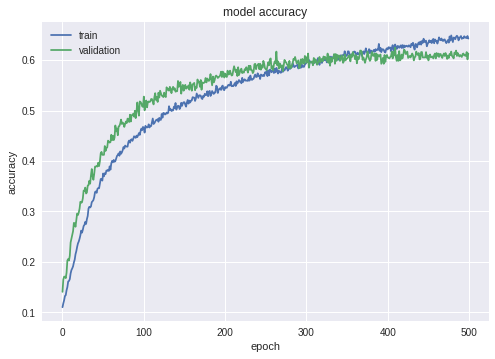

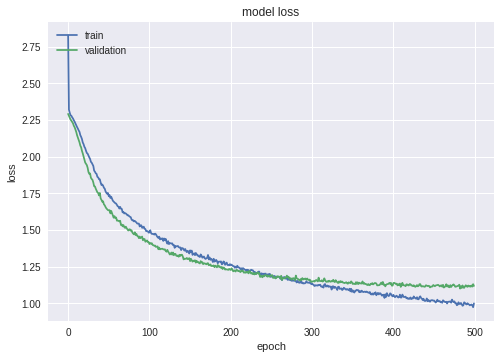

In [0]:
"""
#########################################################################################
################################ Show the Epochs vs ACC #################################
#########################################################################################
"""
# summarize history for accuracy
plt.plot(his.history['acc'])
plt.plot( his.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot( his.history['loss'])
plt.plot( his.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
###########################################################################
################### Evaluate the model ####################################
###########################################################################
scores = model.evaluate(test, test_label,batch_size=batch_size)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

2567/2567 [==============================] - 0s 45us/step

acc: 73.08%


In [0]:
"""
###############################################################################
################ Accuracy and Confusion Matrix ################################
###############################################################################
"""

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print("confusion matrix:\n%s" % cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=85)
    plt.yticks(tick_marks, classes)
    plt.grid(False)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

2567/2567 [==============================] - 0s 92us/step
Confusion Matrix
confusion matrix:
[[172  21   3  27   1   1   7   8   3  10]
 [ 12 150   7  58   2   0   6   8   6   2]
 [  4   2 187   7   6   0  18   2   6  35]
 [ 19  33   4 176   1   0   0   6   8   5]
 [  2   2   6   2 193  13   3   6  35   0]
 [  4   1   1   5  26 190   7   1   9   2]
 [  3   2  17   6   3   5 215   1   0   7]
 [  4  16   7  12   8   1   4 180  14   3]
 [  2   5   5   9  22   4   4  15 204   2]
 [  6   3  14  17   2   1   2   0   2 209]]


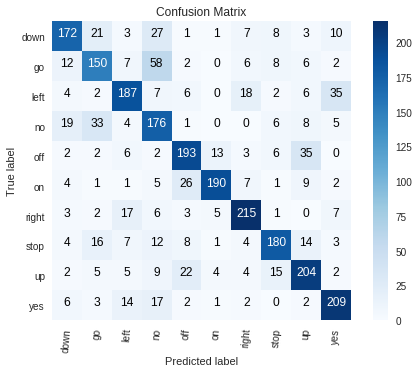

In [0]:
###########################################################################
# Compute confusion matrix
#########################################################################

# labels

command_class=classes.keys()
command_class=list(command_class)

#prediction= model.predict_proba(test,batch_size=batch_size, verbose=1)
y_prob = model.predict_proba(test, verbose=1)
#y_pred = np_utils.probas_to_classes(y_prob)
y_pred = y_prob.argmax(axis=-1)
y_true = np.argmax(test_label, 1)
cm = confusion_matrix(y_true, y_pred, labels=None)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=command_class,
                      title='Confusion Matrix')
plt.show()
#print("confusion matrix:\n%s" % cm)


In [0]:
##########################################################
### Per class accuracy and other metrics
##########################################################


print(classification_report(y_true, y_pred))

#Total count per predicted class
list_classes=[0,1,2,3,4,5,6,7,8,9]
count_list = []
for c in range(0,len(list_classes)):
    for i in range(0,len(cm)):
        if c==i:
            dia=cm[c][i]
            count_list.append(dia)

#Total count per True class
Truecount_list = []
sumTot=0
for c in list_classes:
    sumTot=0
    for i in y_true:
        #print(i)
        if i==c:
            sumTot=sumTot+1
    Truecount_list.append(sumTot)

# per class accuracy
classAcc=[]
for i in range(0,len(Truecount_list)):
    c_Acc=count_list[i]/Truecount_list[i]
    classAcc.append(c_Acc)
print("Per Class Acc: ",classAcc)

# Accuracy 
sumTot=0
for i in classAcc:
  sumTot=sumTot+i
print('Avg Accuracy: ',sumTot/len(classAcc) )
  

             precision    recall  f1-score   support

          0       0.75      0.68      0.72       253
          1       0.64      0.60      0.62       251
          2       0.75      0.70      0.72       267
          3       0.55      0.70      0.62       252
          4       0.73      0.74      0.73       262
          5       0.88      0.77      0.82       246
          6       0.81      0.83      0.82       259
          7       0.79      0.72      0.76       249
          8       0.71      0.75      0.73       272
          9       0.76      0.82      0.79       256

avg / total       0.74      0.73      0.73      2567

Per Class Acc:  [0.6798418972332015, 0.5976095617529881, 0.700374531835206, 0.6984126984126984, 0.7366412213740458, 0.7723577235772358, 0.8301158301158301, 0.7228915662650602, 0.75, 0.81640625]
Avg Accuracy:  0.7304651280566267


In [0]:
###########################################################################
##################3 Evaluate the model ####################################
###########################################################################
scores = model.evaluate(test, test_label,batch_size=batch_size)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

2567/2567 [==============================] - 0s 50us/step

acc: 73.08%


In [0]:
from sklearn.metrics import accuracy_score
